# Pilot 3


In [18]:
import pandas as pd
import numpy as np
import glob
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

### import data

In [19]:
path_to_merged_data = '../pilot3_results/final_merged_data.csv'
merged_df = pd.read_csv(path_to_merged_data)

### clean data

In [20]:
# full dataframe
df = merged_df.copy()


df_clean = df[
    (df['audio_check_passed'] == True) & # pass audio check
    (df['comprehension_failures'] <= 2) & # pass comprehension check
    # remove did not hear sound in LCE and heard sound in SCE
    ((df['condition'] != 'LCE') | (df['heard_sound'] != 'no')) &
    ((df['condition'] != 'SCE') | (df['heard_sound'] != 'yes'))
]


print(f"Number of participants after cleaning: {len(df_clean)}")
print(f"SCE: {len(df_clean[df_clean['condition']=='SCE'])}")
print(f"LCE: {len(df_clean[df_clean['condition']=='LCE'])}")

Number of participants after cleaning: 240
SCE: 120
LCE: 120


### convert confidence to common confidence scale

In [21]:
'''
confidence_scaled calculation
confidence: c

if guess was 2 discs:
    -c/2
if guess was 4 discs:
    c/2
i.e. positive means confident there were 4 discs, negative means confident there were 2 discs
'''
# confidence for plastic discs
df_clean['confidence_scaled'] = np.where(
    df_clean['guess'] == 2.0,          # 2 discs
    -df_clean['confidence'] / 2,       #
    df_clean['confidence'] / 2         # Value if false
)

# confidence for cork discs
df_clean['cork_confidence_scaled'] = np.where(
    df_clean['cork_guess'] == 2.0,          # Condition: if 'guess' is 2
    -df_clean['cork_confidence'] / 2,       # Value if true
    df_clean['cork_confidence'] / 2         # Value if false
)

/var/folders/zq/9fkjxgxj1nsblhs_1v60vjth0000gq/T/ipykernel_31027/3302106535.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['confidence_scaled'] = np.where(
/var/folders/zq/9fkjxgxj1nsblhs_1v60vjth0000gq/T/ipykernel_31027/3302106535.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cork_confidence_scaled'] = np.where(


### summary statistics

In [22]:
# take the difference between confidence responses
df_clean['diff'] = df_clean['confidence_scaled'] - df_clean['cork_confidence_scaled'] # plastic - cork confidence
# positive: more sure that there were four discs, negative: more sure that there were two discs

# SCE
plastic_sce = df_clean[df_clean['condition'] == 'SCE']['confidence_scaled']
cork_sce = df_clean[df_clean['condition'] == 'SCE']['cork_confidence_scaled']
diff_sce = df_clean[df_clean['condition'] == 'SCE']['diff']

# LCE
plastic_lce = df_clean[df_clean['condition'] == 'LCE']['confidence_scaled']
cork_lce = df_clean[df_clean['condition'] == 'LCE']['cork_confidence_scaled']
diff_lce = df_clean[df_clean['condition'] == 'LCE']['diff']

print("Summary statistics of Scaled Confidence: \n")
print(f'plastic SCE:\n{plastic_sce.describe().round(2)}')
print(f'\nplastic LCE:\n{plastic_lce.describe().round(2)}')
print(f'\ncork SCE:\n{cork_sce.describe().round(2)}')
print(f'\ncork LCE:\n{cork_lce.describe().round(2)}')

print('\n------------------------------------\n')
print('Mean and Std of Delta Confidence: \n')
print(f'delta conf SCE:\n{diff_sce.describe().round(2)}')
print(f'\ndelta conf LCE:\n{diff_lce.describe().round(2)}')

Summary statistics of Scaled Confidence: 

plastic SCE:
count    120.00
mean      -0.90
std       24.50
min      -49.50
25%      -21.25
50%        0.00
75%       22.75
max       45.50
Name: confidence_scaled, dtype: float64

plastic LCE:
count    120.00
mean     -10.51
std       25.01
min      -49.50
25%      -31.50
50%      -17.00
75%        7.88
max       48.00
Name: confidence_scaled, dtype: float64

cork SCE:
count    120.00
mean      -5.42
std       25.75
min      -49.50
25%      -25.50
50%       -8.25
75%       18.00
max       49.50
Name: cork_confidence_scaled, dtype: float64

cork LCE:
count    120.00
mean      -8.03
std       27.63
min      -49.50
25%      -31.00
50%      -14.00
75%       18.50
max       46.00
Name: cork_confidence_scaled, dtype: float64

------------------------------------

Mean and Std of Delta Confidence: 

delta conf SCE:
count    120.00
mean       4.52
std       21.56
min      -83.00
25%       -0.62
50%        0.25
75%        6.00
max       92.50
Name: d

/var/folders/zq/9fkjxgxj1nsblhs_1v60vjth0000gq/T/ipykernel_31027/495197022.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['diff'] = df_clean['confidence_scaled'] - df_clean['cork_confidence_scaled'] # plastic - cork confidence


### Plots

#### Figure 1: Distribution of scaled confidence by condition and material

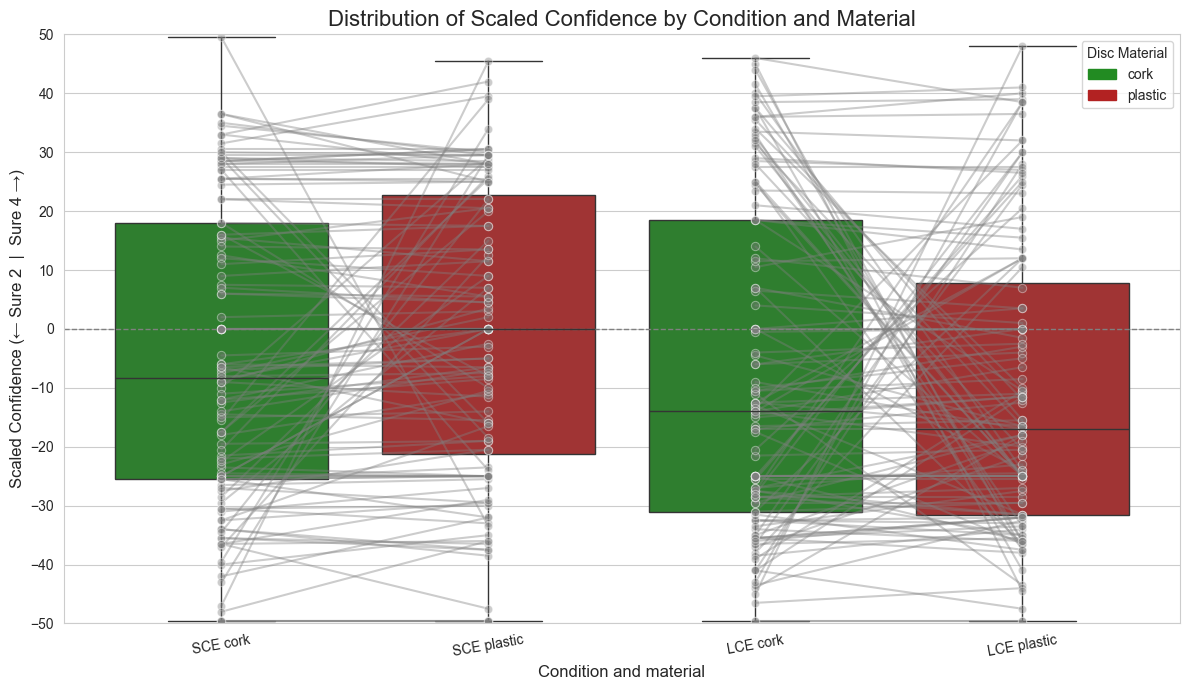

In [23]:
# change format of df for plotting
df_long = pd.melt(
    df_clean,
    id_vars=['subject_id', 'condition'],
    value_vars=['cork_confidence_scaled', 'confidence_scaled'],
    var_name='trial_type',
    value_name='scaled_confidence'
)

label_map = {
    'cork_confidence_scaled': 'cork',
    'confidence_scaled': 'plastic'
}
df_long['x_category'] = df_long['condition'] + ' ' + df_long['trial_type'].map(label_map)

# plotting figure
plt.figure(figsize=(12, 7))

plot_order = [
    'SCE cork',
    'SCE plastic',
    'LCE cork',
    'LCE plastic'
]

custom_palette = {
    'cork_confidence_scaled': 'forestgreen',
    'confidence_scaled': 'firebrick'
}

# box plot of confidence distribution according to condition and material
sns.boxplot(
    data=df_long,
    x='x_category',
    y='scaled_confidence',
    hue='trial_type',
    order=plot_order,
    palette=custom_palette,
    fliersize=0,
    dodge=False
)

# draw line in points within same subject to show directionality
sns.lineplot(
    data=df_long,
    x='x_category',
    y='scaled_confidence',
    units='subject_id',
    estimator=None,
    color='grey',
    alpha=0.4,
    legend=False,
    marker='o'
)

# for the legend
green_patch = mpatches.Patch(color='forestgreen', label='cork')
red_patch = mpatches.Patch(color='firebrick', label='plastic')

plt.legend(handles=[green_patch, red_patch], title="Disc Material")
plt.title('Distribution of Scaled Confidence by Condition and Material', fontsize=16)
plt.xlabel('Condition and material', fontsize=12)
plt.ylabel('Scaled Confidence (← Sure 2  |  Sure 4 →)', fontsize=12)
plt.ylim(-50, 50)
plt.yticks(np.arange(-50, 51, 10))
plt.xticks(rotation=10)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.tight_layout()

plt.show()

#### Figure 2: Delta confidence distribution

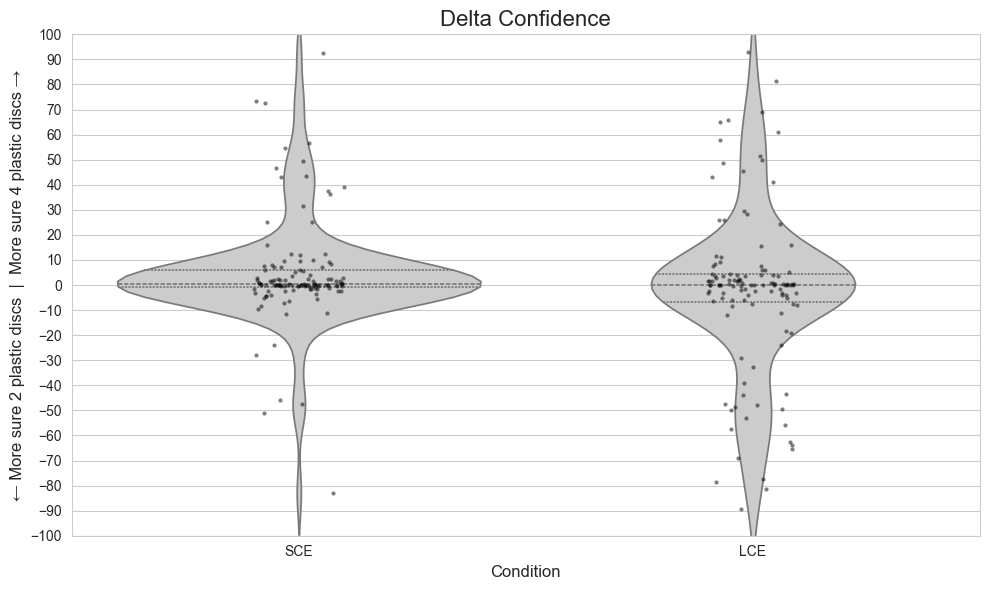

In [24]:
plt.figure(figsize=(10, 6))

# simple violin plot of condition and delta confidence
sns.violinplot(
    data=df_clean,
    x='condition',
    y='diff',
    inner='quart',
    color=".8"
)

# jitter points
sns.stripplot(
    data=df_clean,
    x='condition',
    y='diff',
    jitter=True,
    color='black',
    size=3,
    alpha=0.5
)

plt.title('Delta Confidence', fontsize=16)
plt.xlabel('Condition', fontsize=12)
plt.ylabel('← More sure 2 plastic discs  |  More sure 4 plastic discs →', fontsize=12)
plt.ylim(-100, 100)
plt.yticks(np.arange(-100, 101, 10))
plt.tight_layout()

#### Distribution of collision by condition

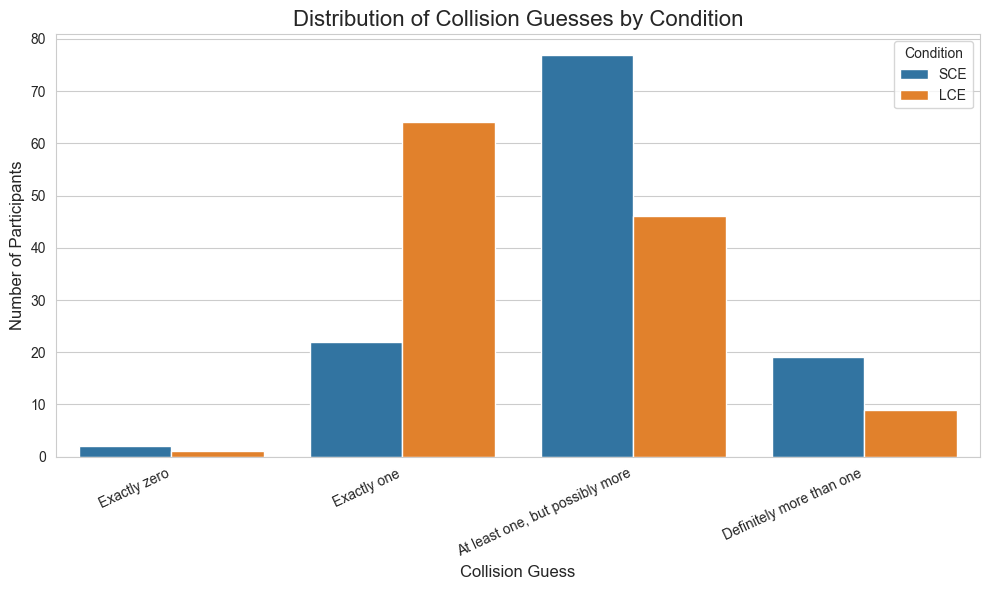

In [25]:
plt.figure(figsize=(10, 6))

category_order = [
    'Exactly zero',
    'Exactly one',
    'At least one, but possibly more',
    'Definitely more than one'
]


sns.countplot(
    data=df_clean,
    x='collision_check',
    hue='condition',
    order=category_order
)

plt.title('Distribution of Collision Guesses by Condition', fontsize=16)
plt.xlabel('Collision Guess', fontsize=12)
plt.ylabel('Number of Participants', fontsize=12)
plt.xticks(rotation=25, ha='right')
plt.legend(title='Condition', loc='upper right')
plt.tight_layout()

#### Distribution of confidence by collision guess (Plastic)

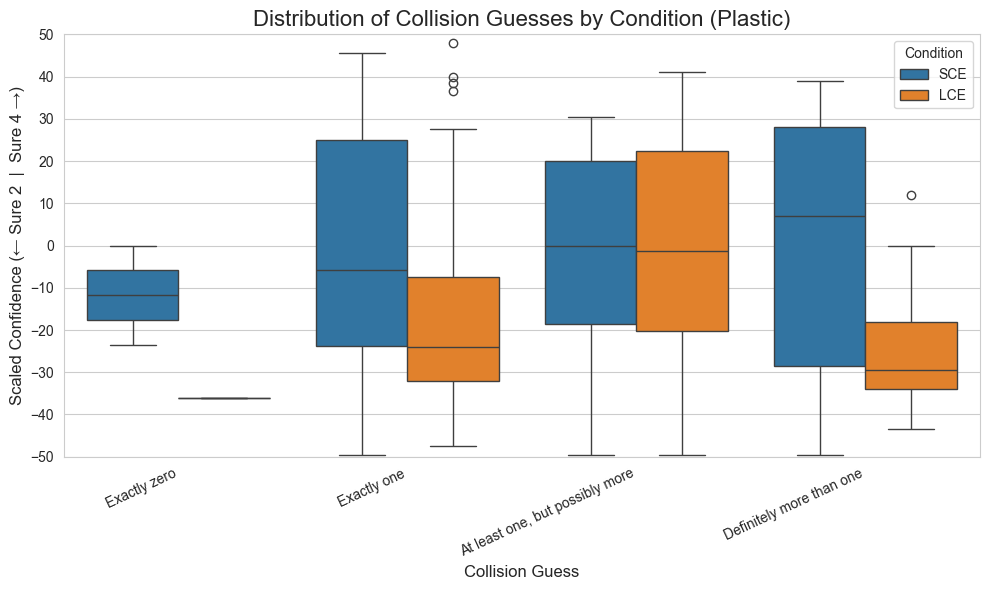

In [26]:
plt.figure(figsize=(10, 6))

category_order = [
    'Exactly zero',
    'Exactly one',
    'At least one, but possibly more',
    'Definitely more than one'
]


sns.boxplot(
    data=df_clean,
    x='collision_check',
    y = 'confidence_scaled',
    hue='condition',
    order=category_order
)


plt.title('Distribution of Collision Guesses by Condition (Plastic)', fontsize=16)
plt.xlabel('Collision Guess', fontsize=12)
plt.ylabel('Scaled Confidence (← Sure 2  |  Sure 4 →)', fontsize=12)
plt.xticks(rotation=25, ha='right')
plt.legend(title='Condition', loc='upper right')
plt.ylim(-50, 50)
plt.yticks(np.arange(-50, 51, 10))
plt.tight_layout()

### analysis

#### function for cohen's d

In [27]:
def cohen_d_independent(x, y):
    """

    Args:
        x: data of one group (array-like)
        y: data of another group (array-like)
        (samples independent of one another)

    Returns:
        float: effect size, cohen's d for independent samples

    """
    len_x, len_y = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)

    pooled_std = np.sqrt(((len_x - 1) * std_x ** 2 + (len_y - 1) * std_y ** 2) / (len_x + len_y - 2))

    if pooled_std == 0:
        return np.inf

    d = (mean_x - mean_y) / pooled_std
    return d

def cohen_d_paired(x, y):
    """

    Args:
        x: first sample (array-like)
        y: second sample (array-like)

    Returns:
        float: effect size, cohen's d for paired samples
    """

    differences = np.array(x) - np.array(y)

    mean_diff = np.mean(differences)

    std_diff = np.std(differences, ddof=1)

    if std_diff == 0:
        return np.inf

    d = mean_diff / std_diff
    return d

#### Independent samples t-test

##### plastic SCE vs LCE

In [28]:
t_statistic, p_value = stats.ttest_ind(plastic_sce, plastic_lce, equal_var=False)

print(f"Independent samples T-test comparing confidence for plastic discs between SCE and LCE conditions.")
print(f"T-statistic: {t_statistic:.5f}")
print(f"P-value: {p_value:.5f}")
print(f"Cohen's d: {cohen_d_independent(plastic_sce, plastic_lce):.5f}")

Independent samples T-test comparing confidence for plastic discs between SCE and LCE conditions.
T-statistic: 3.00484
P-value: 0.00294
Cohen's d: 0.38792


##### cork SCE vs LCE

In [29]:
t_statistic, p_value = stats.ttest_ind(cork_sce, cork_lce, equal_var=False)

print(f"Independent samples T-test comparing confidence for cork discs between SCE and LCE conditions.")
print(f"T-statistic: {t_statistic:.5f}")
print(f"P-value: {p_value:.5f}")
print(f"Cohen's d: {cohen_d_independent(cork_sce, cork_lce):.5f}")

Independent samples T-test comparing confidence for cork discs between SCE and LCE conditions.
T-statistic: 0.75765
P-value: 0.44942
Cohen's d: 0.09781


##### Delta SCE vs LCE

In [30]:
t_statistic, p_value = stats.ttest_ind(diff_sce, diff_lce, equal_var=False )

print(f"Independent samples T-test comparing delta confidence between SCE and LCE conditions.")
print(f"T-statistic: {t_statistic:.5f}")
print(f"P-value: {p_value:.5f}")
print(f"Cohen's d: {cohen_d_independent(diff_sce, diff_lce):.5f}")

Independent samples T-test comparing delta confidence between SCE and LCE conditions.
T-statistic: 1.95493
P-value: 0.05194
Cohen's d: 0.25238


#### Paired samples t-test

In [31]:
t_statistic, p_value = stats.ttest_rel(cork_sce, plastic_sce)

print(f"Paired samples t-test comparing confidence between cork and plastic in SCE.")
print(f"T-statistic: {t_statistic:.5f}")
print(f"P-value: {p_value:.5f}")
print(f"Cohen's d: {cohen_d_paired(cork_sce, plastic_sce):.5f}")

t_statistic, p_value = stats.ttest_rel(cork_lce, plastic_lce)

print("Paired samples t-test comparing confidence between cork and plastic in LCE")
print(f"T-statistic: {t_statistic:.5f}")
print(f"P-value: {p_value:.5f}")
print(f"Cohen's d: {cohen_d_paired(cork_lce, plastic_lce):.5f}")

Paired samples t-test comparing confidence between cork and plastic in SCE.
T-statistic: -2.29450
P-value: 0.02351
Cohen's d: -0.20946
Paired samples t-test comparing confidence between cork and plastic in LCE
T-statistic: 0.82888
P-value: 0.40883
Cohen's d: 0.07567


#### Chi-squared test for collision check responses

In [32]:
contingency_table = pd.crosstab(df_clean['condition'], df_clean['collision_check'])

chi2_stat, p_value, dof, expected_freq = stats.chi2_contingency(contingency_table)

print("Chi-Squared Test Results:")
print(f"Chi-Squared Statistic: {chi2_stat:.5f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p_value:.5f}")

Chi-Squared Test Results:
Chi-Squared Statistic: 32.22940
Degrees of Freedom: 3
P-value: 0.00000


#### Two-way ANOVA

##### two-way ANOVA on plastic confidence

In [33]:
model = ols('confidence_scaled ~ C(collision_check) * C(condition)', data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print('Two-way ANOVA on plastic confidence')
print(anova_table)

Two-way ANOVA on plastic confidence
                                        sum_sq     df         F    PR(>F)
C(collision_check)                 4799.813456    3.0  2.712255  0.045713
C(condition)                       2556.912503    1.0  4.334542  0.038443
C(collision_check):C(condition)    4228.339106    3.0  2.389329  0.069557
Residual                         136854.987022  232.0       NaN       NaN


##### two-way ANOVA on cork confidence

In [34]:
model = ols('cork_confidence_scaled ~ C(collision_check) * C(condition)', data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print('Two-way ANOVA on cork confidence')
print(anova_table)

Two-way ANOVA on cork confidence
                                        sum_sq     df         F    PR(>F)
C(collision_check)                  511.348293    3.0  0.234289  0.872425
C(condition)                        382.446863    1.0  0.525686  0.469157
C(collision_check):C(condition)     492.560525    3.0  0.225680  0.878481
Residual                         168784.455765  232.0       NaN       NaN
